In [122]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250420',
'user':'student',
'password':'dpo_python_2020'
}

q = """
SELECT
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2025-03-21' and toDate(time) <= '2025-03-27'
GROUP BY user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [123]:
df.head()

,user_id,likes,views,ctr
0,13289,2,32,0.062500
1,121096,12,57,0.210526
2,5090,2,14,0.142857
3,129283,23,80,0.287500
4,4394,25,54,0.462963


In [124]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

In [125]:
views_q = """
select views, count() as users
from (select
    user_id,
    sum(action = 'view') as views
from {db}.feed_actions
where toDate(time) >= '2025-03-21' and toDate(time) <= '2025-03-27'
group by user_id
)
group by views
order by views
"""


views_distribution = ph.read_clickhouse(views_q, connection=connection)

In [126]:
views_distribution.head()

,views,users
0,1,4
1,2,1
2,3,4
3,4,5
4,5,18


In [127]:
views_distribution.users.sum()

41997

In [128]:
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()

In [129]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
15,16,545,0.012977
14,15,537,0.012787
13,14,500,0.011906
34,35,485,0.011548
29,30,469,0.011167
...,...,...,...
280,287,1,0.000024
278,285,1,0.000024
276,280,1,0.000024
1,2,1,0.000024


In [130]:
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [131]:
views_distr.mean()

70.30916494035289

In [132]:
views_distr.median()

60.0

In [133]:
views_distr.std()

46.795649294309676

<Axes: ylabel='Count'>

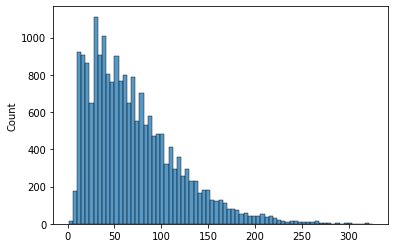

In [134]:
sns.histplot(views_distr.rvs(size=20000))

In [135]:
ctr_q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions
where toDate(time) >= '2025-03-21' and toDate(time) <= '2025-03-27'
group by dt, user_id
)
group by ctr
"""


ctr_distribution = ph.read_clickhouse(ctr_q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [136]:
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
17,0.20,4993,0.058658
33,0.16,4233,0.049729
50,0.25,4216,0.049529
6,0.18,4213,0.049494
72,0.21,3957,0.046487
...,...,...,...
12,0.81,2,0.000023
73,0.83,1,0.000012
20,0.73,1,0.000012
51,1.00,1,0.000012


In [137]:
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']
distrib = stats.rv_discrete(values=(range(len(probabilities)), probabilities))

def get_ctrs(x, y, distrib, values):
    idx = distrib.rvs(size=x*y)
    result = values[idx]
    return np.array(result).reshape(x,y)

In [138]:
get_ctrs(2000, 2000, distrib, values).mean()

0.21220342999999997

In [139]:
get_ctrs(2000, 2000, distrib, values)

array([[0.2 , 0.19, 0.11, ..., 0.29, 0.17, 0.2 ],
       [0.08, 0.21, 0.2 , ..., 0.15, 0.26, 0.17],
       [0.12, 0.15, 0.18, ..., 0.28, 0.25, 0.33],
       ...,
       [0.2 , 0.14, 0.47, ..., 0.23, 0.27, 0.53],
       [0.31, 0.19, 0.4 , ..., 0.11, 0.2 , 0.44],
       [0.23, 0.33, 0.05, ..., 0.31, 0.2 , 0.09]])

In [140]:
std_q = """
select 
   stddevPop(ctr) as ctr_std
from (select toDate(time) as dt,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions
where toDate(time) >= '2025-03-21' and toDate(time) <= '2025-03-27'
group by dt, user_id
)

"""

std = ph.read_clickhouse(std_q, connection=connection).values[0][0]
std

0.098445817847325

In [141]:
compute_sample_size_abs(0.01, std, std)

1522

In [165]:
from tqdm import tqdm

rng = np.random.default_rng()
beta = 0
n = (views_distribution.users.sum()+19897) // 2

In [166]:
for i in tqdm(range(20000)):
    views1 = rng.choice(views_distribution.views, size = n, replace = True, p = views_distribution.p).astype(np.int64)
    views1 = views1 + ((1 + rng.binomial(1, 0.5, size = n)) * rng.binomial(1, 0.9, size = n) * (views1 >= 30))
    views2 = rng.choice(views_distribution.views, size = n, replace = True, p = views_distribution.p).astype(np.int64)
    
    ctr1 = rng.choice(ctr_distribution.ctr, size = n, replace = True, p = ctr_distribution.p)
    ctr2 = rng.choice(ctr_distribution.ctr, size = n, replace = True, p = ctr_distribution.p)
    
    likes1 = rng.binomial(views1, ctr1)
    likes2 = rng.binomial(views2, ctr2)
    
    beta += (stats.ttest_ind(likes2[views2 >= 30], likes1[views1 >= 30], equal_var = False).pvalue <= 0.05)
    result = (beta / 20000) * 100

100%|██████████| 20000/20000 [06:23<00:00, 52.11it/s]


In [167]:
result

64.82

56.41 (Первый результат при выборке (n) 30591)

57.08 второй вариант (тоже верный)

При применении в ТТесте просмотров >=30 результат - 64.82